In [ ]:
#ABBILDUNGEN und ANALYSE (wirtschaftliche Potenzialanalyse)
#1. Packages und paths und Datein öffenen
#2. Funktion aus technischer Potenzialanalyse
#3. Funktion wirtschaftlichkeit
#4. Werte für einzelne Szenarienkombinationen
#4.1. Kostenaufteilung
#4.2. Betrachtung einezelner Komponenten der Kostenaufteilung
#4.3. Gesamtkosten
#4.4. Sensitivitäten
#5. Matrix für alle Szenarienkombinationen
#5.1. Erstellen Matrix für alle Szenarienkombination (Kaufpreis, Restwert, Ladestrategie)
#5.2. Gegenüberstellung Elektro und Diesel Gesamtfuhrpark
#5.3. Gegenüberstellung Elektro und Diesel für jedes Fahrzeug
#5.4. Verlgeich Ladestrategien (Beispielfahrzeug)
#5.5. Vergleich Ladestartegien alle Fahrzeuge

In [28]:
#PACKAGES AND PATHS

#!pip install pandas matplotlib
#!pip install openrouteservice
import pandas as pd
import numpy as np
import six
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import openrouteservice
from openrouteservice import convert
import requests
import json
import re
import os
import pickle
import math
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
api_key = '5b3ce3597851110001cf6248dec4c079cd1b468f979908580f22cc12' #muss ich immer wieder neu erstellen über account: https://openrouteservice.org/dev/#/home
client = openrouteservice.Client(key=api_key)

FZG = ['WT-BR 270','WT-BR 231','WT-BR240', 'WT-BR 391E ', 'FR-BR 1315', 'WT-BR 229', 'WT-BR 228', 'WT-BR 2551', 'WT-BR 608', 'WT-BR 213', 'WT-BR 225', 'WT-BR 253', 'FR-BR 1317']
new_label={'WT-BR 231': 'fzg a','WT-BR240': 'fzg b', 'WT-BR 391E ': 'fzg c', 'FR-BR 1315': 'fzg d', 'WT-BR 270': 'fzg e', 'WT-BR 229': 'fzg f', 'WT-BR 228': 'fzg g', 'WT-BR 2551': 'fzg h', 'WT-BR 608': 'fzg i', 'WT-BR 213': 'fzg j', 'WT-BR 225': 'fzg k', 'WT-BR 253': 'fzg l', 'FR-BR 1317': 'fzg m'}

# datei öffnen
path = 'C:\\Users\\t.dolinga\\Documents\\Bachelorarbeit\\Daten_komplett_1908.xlsx' # Daten
save_path= 'C:\\Users\\t.dolinga\\Documents\\Bachelorarbeit\\Ergebnisse\\' #Speicherort
path_2 = 'C:\\Users\\t.dolinga\\Documents\\Bachelorarbeit\\Preise_Daten.xlsx'
Preise = pd.read_excel(path_2)

#DATEIEN ÖFFNEN
with open(f'{save_path}dfs_big.pkl', 'rb') as file:   
    dfs_big = pickle.load(file)
with open(f'{save_path}dfs_small.pkl', 'rb') as file:   
    dfs_small = pickle.load(file)
df_kennzahlen = pd.read_excel(f'{save_path}kennzahlen.xlsx')
# dfs_big
with open(f'{save_path}matrix_adressen.pkl', 'rb') as file:   
    matrix_adressen = pickle.load(file)

In [29]:
#2. Funktion technische Potenzialanalyse
def Verbraucht(bat_kapa, Szen):
    batteriekapazität=bat_kapa #Szenario 2: 450kWh, Szenario 1: 300kWh, 650kWh
    verbrauch = 1.1 #1.1 kWh pro km 
    Faktor_Ladung = 0.000046 #4,6% pro t Ladung (0,0046% pro kg = 0,000046 pro kg) erhöht sich verbrauch, bei fracht_mean gibt es keinen Effekt
    Faktor_Steigung_mittel_hoch = 1.57 #pro Meter Elevation erhöht/verringert sich verbrauch
    Faktor_Steigung_mittel_runter = 0.51
    Temp_Szenario = 0 # 0= nein, 1=ja
    Temperatur = 0.75
    Temperatur_laden = 0.83
    Ladegeschwindigkeit_lp =1.667 #Szenario: 100kW =1.667 kW/min
    Ladegeschwindigkeit_stopp=0.3333   #Szenario 1: 20kW (0,3333 kW /pro min)
    Ladegeschwindigekti_nacht =0
    Laden_zeitverlust =10 #min die von Pausenzeit abgezogen werden, weil da noch nicht lädt/Vorbereitungszeit
    if Szen==1:
        laden_in_lenkpausen = 1 #0 ist nein, 1 ist ja
        laden_bei_stops = 1 #0 ist nein, 1 ist ja
    elif Szen==2:
        laden_in_lenkpausen = 0 #0 ist nein, 1 ist ja
        laden_bei_stops = 0 #0 ist nein, 1 ist ja
    rows, cols = len(FZG), 10
    bat_check = [] #ür jedes Fahrzeug und Tag wird 0 oder 1 abgespeichert: 0 heißt Batterie hat gereicht, 1 heißt Batterie hat nicht gereicht
    End_bat = [] # für jedes Fahrzeug und Tag wird Endbatteriestand gespeichert
    min_value = []
    fracht_mean=df_kennzahlen['Fracht'].mean()
    fracht_mean
    laden_laderampe= {}
    laden_lp= {}
    km= {}
    laden_nacht= {}
    for _ in range(rows):
        row = [None] * cols
        bat_check.append(row)
        End_bat.append(row)
        min_value.append(row)
    if Temp_Szenario == 1:
        batteriekapazität = batteriekapazität * Temperatur
        Ladegeschwindigkeit_lp =Ladegeschwindigkeit_lp*Temperatur_laden
        Ladegeschwindigkeit_stopp= Ladegeschwindigkeit_stopp * Temperatur_laden
    for fzg in range(len(FZG)): #für jedes Fahrzeug
        df = pd.read_excel(path, sheet_name=FZG[fzg])
        tage=df.iloc[2].count() # zählt alle ausgefüllten Tage (zweite zeile)
        tage=tage-1 # da erste Spalte mit Labeln ist
        Optionen = ['Stopp', 'Fahren']
        lenk = ['Ja', 'Nein', '0']
        time_format = '%H:%M:%S' 
        dfs = {} #hier kommen alle Tage rein
        laden_laderampe[FZG[fzg]]=0
        laden_lp[FZG[fzg]]=0
        km[FZG[fzg]]=0
        laden_nacht[FZG[fzg]]=0
        for tag in range(tage): #für jeden Tage
            akt = 0 #aktionen durchnummerieren
            filter = dfs_small[FZG[fzg]][tag]
            grouped = filter.groupby(['Aktivität']).size()
            fahren_count = grouped['Fahren']
            lenkpause_count = grouped['Lenkpause'] if 'Lenkpause' in grouped else 0
            stopp_count = grouped['Stopp']
        
        #Erstellen von dataframe für Verbräuche: Verbrauch (+/-) , Länge , Gesamtverbrauch
        # Idee = erstellen von dataframe punkten (Energiestand und uhrzeit -> die können am Ende verbunden werde)

            #if laden_in_lenkpausen ==1 & laden_bei_stops == 1:# länge der verbrauchsaktionen definieren (mit oder ohne Lenkpause)
            verb = [None]* (fahren_count+lenkpause_count + stopp_count+1)
            lang = [None]* (fahren_count+lenkpause_count + stopp_count+1)
            bat = [None]* (fahren_count+lenkpause_count + stopp_count+1)
            
            #Höhenmeter pro km
            dfs_big[FZG[fzg]][tag]['Elev pro km']= dfs_big[FZG[fzg]][tag]['Elevation']/dfs_big[FZG[fzg]][tag]['Distanz']
            bat[0]=batteriekapazität
            lang[0]= dfs_big[FZG[fzg]][tag]['End Time'][0]
            verb[akt]=0.0
    
            for i in range(len(dfs_big[FZG[fzg]][tag]['Aktivität'])): #durch einen Tag (alle ungeraden sind Fahrten)
                dfs
                batterie=batteriekapazität
                if i % 2 != 0:
                    akt=akt+1
                    if dfs_big[FZG[fzg]][tag]['Elev pro km'][i]>10:
                        Steigung = Faktor_Steigung_mittel_hoch
                    elif dfs_big[FZG[fzg]][tag]['Elev pro km'][i]<-10:
                        Steigung = Faktor_Steigung_mittel_runter
                    else:
                        Steigung=1.0

                    lang[akt]=dfs_big[FZG[fzg]][tag]['End Time'][i]
                    if dfs_big[FZG[fzg]][tag]['Lenkpause'][i]==lenk[0]: #falls Lenkpause 
                        if laden_in_lenkpausen==1: #Falls während Lenkpause Laden
                            dauer = dfs_big[FZG[fzg]][tag]['Lenkpause lang'][i]
                            total_minutes = int(dauer.total_seconds() / 60) #konvertiert time delta zu int
                            if total_minutes>Laden_zeitverlust: #nur wenn Lenkpause länger als 10min
                                lp_laden=(Ladegeschwindigkeit_lp*(total_minutes-Laden_zeitverlust))
                                laden_lp[FZG[fzg]]=laden_lp[FZG[fzg]]+lp_laden
                                verb[akt]=((verbrauch*(1+Faktor_Ladung*(dfs_big[FZG[fzg]][tag]['Fracht'][i]-fracht_mean)))*Steigung)*dfs_big[FZG[fzg]][tag]['Distanz'][i]-lp_laden
                                km[FZG[fzg]]=km[FZG[fzg]]+dfs_big[FZG[fzg]][tag]['Distanz'][i]
                            else:
                                verb[akt]=((verbrauch*(1+Faktor_Ladung*(dfs_big[FZG[fzg]][tag]['Fracht'][i]-fracht_mean)))*Steigung)*dfs_big[FZG[fzg]][tag]['Distanz'][i]
                                km[FZG[fzg]]=km[FZG[fzg]]+dfs_big[FZG[fzg]][tag]['Distanz'][i]
                            batterie = batterie+verb[akt]
                            lang[akt]=dfs_big[FZG[fzg]][tag]['End Time'][i]
                            if i>0:
                                bat[akt]=bat[akt-1]-verb[akt]
                        else:
                            lang[akt]=dfs_big[FZG[fzg]][tag]['End Time'][i]
                            verb[akt]=((verbrauch*(1+Faktor_Ladung*(dfs_big[FZG[fzg]][tag]['Fracht'][i]-fracht_mean)))*Steigung)*dfs_big[FZG[fzg]][tag]['Distanz'][i]
                            km[FZG[fzg]]=km[FZG[fzg]]+dfs_big[FZG[fzg]][tag]['Distanz'][i]
                            if i>0:
                                bat[akt]=bat[akt-1]-verb[akt]
                    else: 
                        #Verbrauch= (grundverbrauch + Fracht Faktor*Fracht + Steigungsfaktor*Elev) *Strecke (Temp Korrektur wurde schon gemacht)
                        verb[akt]=((verbrauch*(1+Faktor_Ladung*(dfs_big[FZG[fzg]][tag]['Fracht'][i]-fracht_mean)))*Steigung)*dfs_big[FZG[fzg]][tag]['Distanz'][i]
                        km[FZG[fzg]]=km[FZG[fzg]]+dfs_big[FZG[fzg]][tag]['Distanz'][i]
                        lang[akt]=dfs_big[FZG[fzg]][tag]['End Time'][i]
                        if i>0:
                            bat[akt]=bat[akt-1]-verb[akt]

                else:
                    akt=akt+1
                    if laden_bei_stops ==1 and akt!=1 and akt != len(dfs_big[FZG[fzg]][tag]['Aktivität']):
                        dauer=dfs_big[FZG[fzg]][tag]['Duration'][i]
                        total_minutes = int(dauer.total_seconds() / 60)
                        laden_stopp=(total_minutes-Laden_zeitverlust)*Ladegeschwindigkeit_stopp
                        if bat[akt-1]+laden_stopp >= batteriekapazität:
                            laden_stopp=batteriekapazität-bat[akt-1]
                        verb[akt]=-laden_stopp
                        bat[akt]=bat[akt-1]-verb[akt]
                        laden_laderampe[FZG[fzg]]=laden_laderampe[FZG[fzg]]+laden_stopp
                    else: 
                        verb[akt]=0
                        bat[akt]=bat[akt-1]
                    lang[akt]=dfs_big[FZG[fzg]][tag]['End Time'][i]
    
                #Ist Batterie unter Minimum gegeangen?
    
                bat_list=[]
                bat_list = [value for value in bat if value is not None and pd.notna(value)]
                #bat_list = [float(value) for value in bat if value is not None]
            
                    # Get the minimum value from the filtered list (wie siehts mit dem Batteriestand aus?
                min_value[fzg][tag] = min(bat_list)
                #a=bat_list[-1]
                End_bat[fzg][tag]=bat_list[-1]

    distanz={}
    for fzg in range(len(FZG)): #für jedes Fahrzeug
        #print('Fahrzeug:', FZG[fzg])
        df = pd.read_excel(path, sheet_name=FZG[fzg])
        tage=df.iloc[2].count() # zählt alle ausgefüllten Tage (zweite zeile)
        tage=tage-1 # da erste Spalte mit Labeln ist
        distanz[FZG[fzg]]=0
        for tag in range(tage):
            fahren_lang = dfs_big[FZG[fzg]][tag].loc[dfs_big[FZG[fzg]][tag]['Aktivität'] == 'Fahren', 'Distanz']
            fahren_tag=sum(fahren_lang)
            distanz[FZG[fzg]]=distanz[FZG[fzg]]+fahren_tag
    
    
    #Nacht laden
    laden_nacht={}
    for fzg in range(len(FZG)): #für jedes Fahrzeug
        df = pd.read_excel(path, sheet_name=FZG[fzg])
        tage=df.iloc[2].count() # zählt alle ausgefüllten Tage (zweite zeile)
        tage=tage-1 # da erste Spalte mit Labeln ist
        laden_nacht[FZG[fzg]]=0
        
        for tag in range(tage): #für jeden Tage
            laden_nacht[FZG[fzg]]=laden_nacht[FZG[fzg]]+(batteriekapazität-End_bat[fzg][tag])
    
    #608 und 231 einen Tag rausgenommen
    fzg='WT-BR 231'
    df = pd.read_excel(path, sheet_name=fzg)
    tage=df.iloc[2].count()
    tage=tage-1.
    distanz[fzg]=distanz[fzg]+(distanz[fzg]/tage)
    laden_nacht[fzg]=laden_nacht[fzg]+(laden_nacht[fzg]/tage)
    laden_laderampe[fzg]=laden_laderampe[fzg]+(laden_laderampe[fzg]/tage)
    laden_lp[fzg]=laden_lp[fzg]+(laden_lp[fzg]/tage)
    

    
    fzg='WT-BR 608'
    df = pd.read_excel(path, sheet_name=fzg)
    tage=df.iloc[2].count()
    tage=tage-1.
    distanz[fzg]=distanz[fzg]+(distanz[fzg]/tage)
    laden_nacht[fzg]=laden_nacht[fzg]+(laden_nacht[fzg]/tage)
    laden_laderampe[fzg]=laden_laderampe[fzg]+(laden_laderampe[fzg]/tage)
    laden_lp[fzg]=laden_lp[fzg]+(laden_lp[fzg]/tage)
    
    FZG_groß=['WT-BR 231', 'WT-BR240','WT-BR 229', 'WT-BR 228','WT-BR 2551', 'WT-BR 608', 'WT-BR 213', 'WT-BR 225', 'WT-BR 253']
    FZG_klein=['WT-BR 391E ','WT-BR 270', 'FR-BR 1315', 'FR-BR 1317']
    
    kleine_lkw={}
    große_lkw={}
    for fzg in range(len(FZG)):
        if FZG[fzg] in FZG_groß:
            große_lkw[FZG[fzg]]=distanz[FZG[fzg]]
        else:
            kleine_lkw[FZG[fzg]]=distanz[FZG[fzg]]
    return laden_laderampe, laden_lp, End_bat, batteriekapazität, distanz, große_lkw, kleine_lkw, FZG_groß, FZG_klein, laden_nacht

In [30]:
#3. Funktionen wirtschaftlichkeit
def Kalkulationszins(wert, jahre):
    wert_neu = wert*(1/(1.011)**jahre)
    return wert_neu
    
def Inflation(wert, jahre):
    wert_neu=wert*(1/(1.024)**jahre)
    return wert_neu

def Abschreibung(Lkw_Preis_klein, Lkw_Preis_groß, jahr, fzg):
    if jahr >8:
        abschreib=0
    else:
        if FZG[fzg] in FZG_groß:
            abschreib=(Lkw_Preis_groß*0.3/9)
        else:
            abschreib=(Lkw_Preis_klein*0.3/9)
    return abschreib
    
def Abschreibung_2(LadeI, jahr):
    if jahr >18:
        abschreib=0
    else:
        abschreib=(LadeI*0.3/19)
    return abschreib
    
def Abschreibung_3(Batterie, jahr):
    if jahr >9:
        abschreib=0
    else:
        abschreib=(Batterie*0.3/10)
    return abschreib
    
    
def Dieselpreis(jahr, maut):
    dpreis=(Preise['Diesel-Preis [/l]'][jahr] + maut)
    return dpreis

def Strompreis(Preis, jahr):
    faktor=Preise['Stromfaktor'][jahr]
    spreis=Preis*faktor
    return spreis

def Diesel_verbrauch(fzg, jahr, diesel_verbrauch_klein, diesel_verbrauch_groß, maut):
    if FZG[fzg] in FZG_groß:
        verbrauch=große_lkw[FZG[fzg]]*diesel_verbrauch_groß*Dieselpreis(jahr, maut)
    else:
        verbrauch=kleine_lkw[FZG[fzg]]*diesel_verbrauch_klein*Dieselpreis(jahr, maut)
    return verbrauch

def Restwert(fzg, jahr, Lkw_Preis_klein, Lkw_Preis_groß, Restwert_szenario, fzg_diesel_preis_groß, fzg_diesel_preis_klein):
    if Restwert_szenario==0: #Gleicher Wert bei Restwert (Batterie exklusiv)
        if FZG[fzg] in FZG_groß:
            restwert=(math.exp(-1.62*große_lkw[FZG[fzg]]*jahr/1000000)*math.exp(-354*jahr/10000))*fzg_diesel_preis_groß
        else:
            restwert=(math.exp(-1.36*kleine_lkw[FZG[fzg]]*jahr/1000000)*math.exp(-876*jahr/10000))*fzg_diesel_preis_klein
    elif Restwert_szenario==1: # Gleiche Kurve bei Restwert (Batterie exklusiv)
        if FZG[fzg] in FZG_groß:
            restwert=(math.exp(-1.62*große_lkw[FZG[fzg]]*jahr/1000000)*math.exp(-354*jahr/10000))*Lkw_Preis_groß
        else:
            restwert=(math.exp(-1.36*kleine_lkw[FZG[fzg]]*jahr/1000000)*math.exp(-876*jahr/10000))*Lkw_Preis_klein
    return restwert

def RestwertI(preis, jahr): #Idee nach 19 Jahren nur noch 5% wert, sonst linear
    restwert=preis*(-0.05*jahr+1)
    return restwert

def preisB(fzg, Batteriepreis, kleine_bat, mittlere_bat, große_bat):
    if FZG[fzg] in kleine_bat:
        preisB=Batteriepreis*300
    elif FZG[fzg] in mittlere_bat:
        preisB=Batteriepreis*450
    elif FZG[fzg] in große_bat:
        preisB=Batteriepreis*650
    return preisB

def RestwertB(fzg, jahr, Batteriepreis, kleine_bat, mittlere_bat, große_bat):
    if FZG[fzg] in kleine_bat:
        restWB=(Batteriepreis*300)*(1-0.023)**jahr
    elif FZG[fzg] in mittlere_bat:
        restWB=(Batteriepreis*450)*(1-0.023)**jahr
    elif FZG[fzg] in große_bat:
        restWB=(Batteriepreis*650)*(1-0.023)**jahr
    return restWB

def Kosten(Lade_s, kosten_s, Restwert_s):
    if Lade_s==1:
        Szenario=1
    elif Lade_s==2:
        Szenario=2
    if kosten_s==0:
        kosten_sz=0
    elif kosten_s==1:
        kosten_sz=1
    if Restwert_s==0:
        Restwert_szenario=0
    elif Restwert_s==1:
        Restwert_szenario=1
    restwert_e={}
    restwert_d={}
    restwert_B={}
    restwert_I={}
    betrieb_d={}
    betrieb_e={}
    betrieb_d_abschreibung={}
    betrieb_e_abschreibung={}
    einmal_d={}
    einmal_e={}
    aufteilung_e={}
    aufteilung_d={}
    #Jahre=5
    # FZG=['WT-BR 231','WT-BR240', 'WT-BR 391E ', 'FR-BR 1315', 'WT-BR 270', 'WT-BR 229', 'WT-BR 228', 'WT-BR 2551', 'WT-BR 608', 'WT-BR 213', 'WT-BR 225', 'WT-BR 253', 'FR-BR 1317'] 
    kleine_bat_list=[]
    if kosten_sz==0:
        fzg_diesel_preis_klein=128000
        fzg_diesel_preis_groß=140000
        fzg_elektro_preis_klein=192064
        fzg_elektro_preis_groß=204516
    elif kosten_sz==1:
        fzg_diesel_preis_klein=89500
        fzg_diesel_preis_groß=103000
        fzg_elektro_preis_klein=104800
        fzg_elektro_preis_groß=126900

    if Szenario==1: #mit zwischenladen
        ladeinfrastruktur_einmal=(806*88.67)/len(FZG)
        kleine_bat=[FZG[4], FZG[3], FZG[5], FZG[8], FZG[9], FZG[12]]
        mittlere_bat=[FZG[1], FZG[2], FZG[6], FZG[11], FZG[7], FZG[0]]
        große_bat=[FZG[10]]
    elif Szenario ==2: #ohne zwischenladen
        ladeinfrastruktur_einmal=(806*156.98)/len(FZG)
        kleine_bat=[FZG[3], FZG[9], FZG[12]]
        mittlere_bat=[FZG[1], FZG[2], FZG[6], FZG[11], FZG[7], FZG[4], FZG[5], FZG[8]]
        große_bat=[FZG[0], FZG[10]]
    ladeinfrastruktur_jährlich=(ladeinfrastruktur_einmal*0.02)
    Batteriepreis=107  #107€/kWh (2025), 80$/kWh (2030)
    elektro = {}
    fzg_elektro = {}
    maut= 0.53 #€/l
    laden_lp_preis=0.298
    laden_lr_preis= 0.263
    laden_nacht_preis=0.2
    diesel_verbrauch_klein=0.216 #18-26t: AB 21,6 l/100km; AO 21,1 l/100km; IO 27 l/100km  // >26t: AB 25,8 l/100km AO 25,6  l/100km; IO 36,7 l/100km
    diesel_verbrauch_groß=0.256
    # Ziel= für jedes Fahrzeug Diesel und Elektro kosten
    kosten_elektro={}
    kosten_diesel={}
    diff={}
    Jahre_all=16
    for fzg in range(len(FZG)):
        kosten_elektro[FZG[fzg]]={}
        kosten_diesel[FZG[fzg]]={}
        diff[FZG[fzg]]={}
        restwert_e[FZG[fzg]]={}
        restwert_d[FZG[fzg]]={}
        restwert_B[FZG[fzg]]={}
        restwert_I[FZG[fzg]]={}
        betrieb_d[FZG[fzg]]={}
        betrieb_e[FZG[fzg]]={}
        einmal_d[FZG[fzg]]={}
        einmal_e[FZG[fzg]]={}
        aufteilung_e[FZG[fzg]]={}
        aufteilung_d[FZG[fzg]]={}
        betrieb_d_abschreibung[FZG[fzg]]={}
        betrieb_e_abschreibung[FZG[fzg]]={}
        for jahresszenario in range(1, Jahre_all + 1):
            Jahre=jahresszenario
            
            kosten_elektro[FZG[fzg]][jahresszenario]=0
            kosten_diesel[FZG[fzg]][jahresszenario]=0
            betrieb_d[FZG[fzg]][jahresszenario]=0
            betrieb_e[FZG[fzg]][jahresszenario]=0
            betrieb_d_abschreibung[FZG[fzg]][jahresszenario]=0
            betrieb_e_abschreibung[FZG[fzg]][jahresszenario]=0
            aufteilung_e[FZG[fzg]][jahresszenario]={}
            aufteilung_d[FZG[fzg]][jahresszenario]={}

            for jahr in range(Jahre):
                #Diesel(jährlich)
                a1=Abschreibung(fzg_diesel_preis_klein, fzg_diesel_preis_groß, jahr, fzg) #Abschreibung
                k1=25*Diesel_verbrauch(fzg, jahr, diesel_verbrauch_klein, diesel_verbrauch_groß, maut)
                k11=k1-a1
                k2=Kalkulationszins(k11, jahr)
                k3=Inflation(k2, jahr)
                kosten_diesel[FZG[fzg]][jahresszenario]=kosten_diesel[FZG[fzg]][jahresszenario]+k3
                #Elektro(jährlich)
                a_fzg=Abschreibung(fzg_elektro_preis_klein, fzg_elektro_preis_groß, jahr, fzg)
                a_laden=Abschreibung_2(ladeinfrastruktur_einmal, jahr)
                a_bat=Abschreibung_3(preisB(fzg, Batteriepreis, kleine_bat, mittlere_bat, große_bat), jahr)
                strom=25*((laden_nacht[FZG[fzg]]*laden_nacht_preis)+(laden_lp[FZG[fzg]]*laden_lp_preis)+(laden_laderampe[FZG[fzg]]*laden_lr_preis))
                strom=Strompreis(strom, jahr)
                k4=strom+ladeinfrastruktur_jährlich-a_fzg-a_laden-a_bat
                k5=Kalkulationszins(k4, jahr)
                k6=Inflation(k5, jahr)
                kosten_elektro[FZG[fzg]][jahresszenario]=kosten_elektro[FZG[fzg]][jahresszenario]+k6
                
                #In einzelteile unterteilen und überprüfen
                b_d=Inflation(Kalkulationszins(k1, jahr), jahr)
                #b_d=k1
                b_d_a=Inflation(Kalkulationszins(a1, jahr), jahr)
                b_e=Inflation(Kalkulationszins((strom+ladeinfrastruktur_jährlich), jahr), jahr)
                #b_e=strom+ladeinfrastruktur_jährlich
                b_e_a=Inflation(Kalkulationszins((a_fzg+a_laden+a_bat), jahr), jahr)
                betrieb_d[FZG[fzg]][jahresszenario]=betrieb_d[FZG[fzg]][jahresszenario]+ b_d
                betrieb_e[FZG[fzg]][jahresszenario]= betrieb_e[FZG[fzg]][jahresszenario]+b_e
                betrieb_d_abschreibung[FZG[fzg]][jahresszenario]=betrieb_d_abschreibung[FZG[fzg]][jahresszenario]+ b_d_a
                betrieb_e_abschreibung[FZG[fzg]][jahresszenario]= betrieb_e_abschreibung[FZG[fzg]][jahresszenario]+b_e_a
            #Diesel(einmal)
            restW_d=Restwert(fzg, jahresszenario, fzg_diesel_preis_klein, fzg_diesel_preis_groß, Restwert_szenario, fzg_diesel_preis_groß, fzg_diesel_preis_klein)
            restW_d=Kalkulationszins(restW_d, jahresszenario)
            restW_d=Inflation(restW_d, jahresszenario)
            if FZG[fzg] in FZG_groß:
                kosten_diesel[FZG[fzg]][jahresszenario]=kosten_diesel[FZG[fzg]][jahresszenario]+fzg_diesel_preis_groß-restW_d
                einmal_d[FZG[fzg]][jahresszenario]=fzg_diesel_preis_groß-restW_d
                #einmal_d[FZG[fzg]][jahresszenario]=fzg_diesel_preis_groß-Restwert(fzg, jahresszenario, fzg_diesel_preis_klein, fzg_diesel_preis_groß, Restwert_szenario)
                aufteilung_d[FZG[fzg]][jahresszenario]['Kosten Fzg - Restwert']=fzg_diesel_preis_groß-restW_d
            else:
                kosten_diesel[FZG[fzg]][jahresszenario]=kosten_diesel[FZG[fzg]][jahresszenario]+fzg_diesel_preis_klein-restW_d
                einmal_d[FZG[fzg]][jahresszenario]=fzg_diesel_preis_klein-restW_d
                #einmal_d[FZG[fzg]][jahresszenario]=fzg_diesel_preis_klein-Restwert(fzg, jahresszenario, fzg_diesel_preis_klein, fzg_diesel_preis_groß, Restwert_szenario)
                aufteilung_d[FZG[fzg]][jahresszenario]['Kosten Fzg - Restwert']=fzg_diesel_preis_klein-restW_d
            #Elektro(einmal)
            restW_e_fzg=Restwert(fzg, jahresszenario, fzg_elektro_preis_klein, fzg_elektro_preis_groß, Restwert_szenario, fzg_diesel_preis_groß, fzg_diesel_preis_klein)
            restW_e_Lade=RestwertI(ladeinfrastruktur_einmal, jahresszenario)
            restW_e_Batterie=RestwertB(fzg, jahresszenario, Batteriepreis, kleine_bat, mittlere_bat, große_bat)
            restW_e=restW_e_fzg+restW_e_Lade+restW_e_Batterie
            restW_e1=restW_e_Batterie+restW_e_fzg
            restW_e=Kalkulationszins(restW_e, jahresszenario)
            restW_e=Inflation(restW_e, jahresszenario)
            kosten_e_batterie=preisB(fzg, Batteriepreis, kleine_bat, mittlere_bat, große_bat)
            if FZG[fzg] in FZG_groß:
                kosten_elektro[FZG[fzg]][jahresszenario]=kosten_elektro[FZG[fzg]][jahresszenario]+fzg_elektro_preis_groß+kosten_e_batterie+ladeinfrastruktur_einmal-restW_e
                einmal_e[FZG[fzg]][jahresszenario]=fzg_elektro_preis_groß+kosten_e_batterie+ladeinfrastruktur_einmal-restW_e
                #einmal_e[FZG[fzg]][jahresszenario]=fzg_elektro_preis_groß-Restwert(fzg, jahresszenario, fzg_elektro_preis_klein, fzg_elektro_preis_groß, Restwert_szenario)
                aufteilung_e[FZG[fzg]][jahresszenario]['Kosten Fzg - Restwert']=fzg_elektro_preis_groß+kosten_e_batterie-Inflation(Kalkulationszins(restW_e1, jahresszenario), jahresszenario)
            else:
                kosten_elektro[FZG[fzg]][jahresszenario]=kosten_elektro[FZG[fzg]][jahresszenario]+fzg_elektro_preis_klein+ladeinfrastruktur_einmal+kosten_e_batterie-restW_e
                einmal_e[FZG[fzg]][jahresszenario]=fzg_elektro_preis_klein+kosten_e_batterie+ladeinfrastruktur_einmal-restW_e
                #einmal_e[FZG[fzg]][jahresszenario]=fzg_elektro_preis_klein-Restwert(fzg, jahresszenario, fzg_elektro_preis_klein, fzg_elektro_preis_groß, Restwert_szenario)
                aufteilung_e[FZG[fzg]][jahresszenario]['Kosten Fzg - Restwert']=fzg_elektro_preis_klein+kosten_e_batterie-Inflation(Kalkulationszins(restW_e1, jahresszenario), jahresszenario)
            
            diff[FZG[fzg]][jahresszenario]= kosten_elektro[FZG[fzg]][jahresszenario]/kosten_diesel[FZG[fzg]][jahresszenario]
            restwert_I[FZG[fzg]][jahresszenario]=Inflation(Kalkulationszins(restW_e_Lade, jahresszenario), jahresszenario)
            #restwert_I[FZG[fzg]][jahresszenario]=restW_e_Lade
            restwert_e[FZG[fzg]][jahresszenario]=Inflation(Kalkulationszins(restW_e_fzg, jahresszenario), jahresszenario)
            #restwert_e[FZG[fzg]][jahresszenario]=restW_e_fzg
            restwert_d[FZG[fzg]][jahresszenario]=Inflation(Kalkulationszins(Restwert(fzg, jahresszenario, fzg_diesel_preis_klein, fzg_diesel_preis_groß, Restwert_szenario, fzg_diesel_preis_groß, fzg_diesel_preis_klein), jahresszenario),jahresszenario)
            #restwert_d[FZG[fzg]][jahresszenario]=Restwert(fzg, jahresszenario, fzg_diesel_preis_klein, fzg_diesel_preis_groß, Restwert_szenario)
            restwert_B[FZG[fzg]][jahresszenario]=restW_e_Batterie
            aufteilung_e[FZG[fzg]][jahresszenario]['Betrieb']=betrieb_e[FZG[fzg]][jahresszenario]
            aufteilung_e[FZG[fzg]][jahresszenario]['Abschreibung']=-betrieb_e_abschreibung[FZG[fzg]][jahresszenario]
            aufteilung_e[FZG[fzg]][jahresszenario]['Kosten LadeI - Restwert']=ladeinfrastruktur_einmal-Inflation(Kalkulationszins(restW_e_Lade, jahresszenario), jahresszenario)
            aufteilung_d[FZG[fzg]][jahresszenario]['Betrieb']=betrieb_d[FZG[fzg]][jahresszenario]
            aufteilung_d[FZG[fzg]][jahresszenario]['Abschreibung']=-betrieb_d_abschreibung[FZG[fzg]][jahresszenario]
    return kosten_elektro, kosten_diesel, aufteilung_e, aufteilung_d, restwert_I, restwert_e, restwert_d, betrieb_e, betrieb_d, einmal_d, einmal_e, betrieb_d_abschreibung, betrieb_e_abschreibung, diff, restwert_B


In [37]:
#4. Werte für einzelne Szenarienkombinationen
Szenario_fest= 2  #Szenario 1= mit zwila #Szenario 2=ohne Zwila
kosten_szenario=0 #0 = Rothaus angaben, #1= IFEU angaben
Restwert_szenario=1 #0: elektro gleicher wert wie Diesel; 1 elektro gleiche Kurve wie diesle

b=Verbraucht(650, Szenario_fest)
laden_laderampe=b[0]
laden_lp=b[1]
laden_nacht=b[9]
End_bat=b[2]
batteriekapazität=b[3]
distanz=b[4]
große_lkw=b[5]
kleine_lkw=b[6]
FZG_groß=b[7]
FZG_klein=b[8]


a=Kosten(Szenario_fest, kosten_szenario, Restwert_szenario)
kosten_elektro=a[0]
kosten_diesel=a[1]
aufteilung_e=a[2]
aufteilung_d=a[3]
restwert_I=a[4]
restwert_e=a[5]
restwert_d=a[6]
betrieb_e=a[7]
betrieb_d=a[8]
einmal_d=a[9]
einmal_e=a[10]
betrieb_d_abschreibung=a[11]
betrieb_e_abschreibung=a[12]
diff=a[13]
restwert_b=a[14]

WT-BR 270
WT-BR 231
WT-BR240
WT-BR 391E 
FR-BR 1315
WT-BR 229
WT-BR 228
WT-BR 2551
WT-BR 608
WT-BR 213
WT-BR 225
WT-BR 253
FR-BR 1317


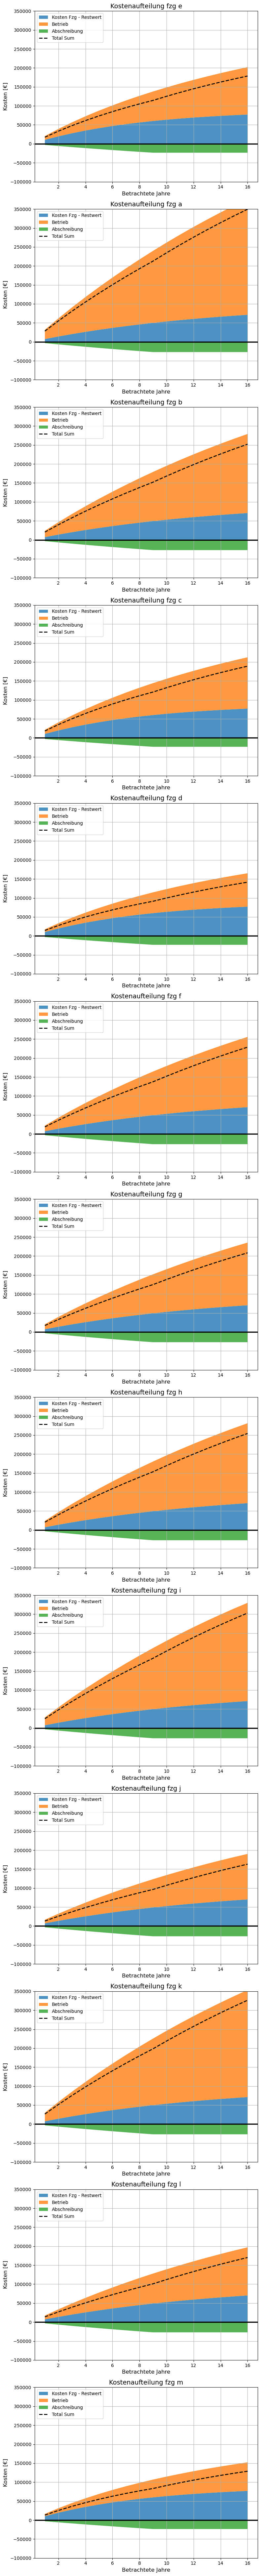

In [32]:
#4.1. Kostenaufteilung der Szenariokombination

aufteilung=aufteilung_d # aufteilung_e (elektro lkw) oder aufteilung_d (diesel Lkw)

# Create subplots for each vehicle (fzg)
fig, axes = plt.subplots(len(aufteilung), 1, figsize=(8, 6 * len(aufteilung)))  # One plot per vehicle (fzg)

# Ensure axes is a list even when we have a single subplot
if len(aufteilung) == 1:
    axes = [axes]

# Loop through each vehicle (fzg)
for i, (fzg, years_data) in enumerate(aufteilung.items()):
    print(fzg)
    # Convert the nested dictionary to a DataFrame
    df = pd.DataFrame(years_data).T  # Transpose to get years as the index

    # Separate positive and negative values
    positive_df = df.clip(lower=0)
    negative_df = df.clip(upper=0)

    # Plot positive values with stackplot
    axes[i].stackplot(positive_df.index, positive_df.T, labels=positive_df.columns, alpha=0.8)

    # Plot negative values using fill_between
    for column in negative_df.columns:
        axes[i].fill_between(negative_df.index, negative_df[column], 0, alpha=0.8)

    # Calculate and plot the actual sum (including negatives)
    total_sum = df.sum(axis=1)
    axes[i].plot(df.index, total_sum, color='black', linewidth=2, label='Total Sum', linestyle='--')

    # Add grid
    axes[i].grid(True)
    axes[i].axhline(0, color='black', linewidth=2.5, linestyle='-')  # Thicker y=0 line
    axes[i].set_ylim(-100000, 350000) #y limit nach oben und unten


    # Add title and labels
    axes[i].set_title(f'Kostenaufteilung {new_label[fzg]}', fontsize=14)
    axes[i].set_xlabel('Betrachtete Jahre', fontsize=12)
    axes[i].set_ylabel('Kosten [€]', fontsize=12)
    axes[i].legend(loc='upper left', fontsize=10)
    
# Adjust layout
plt.tight_layout()
plt.show()

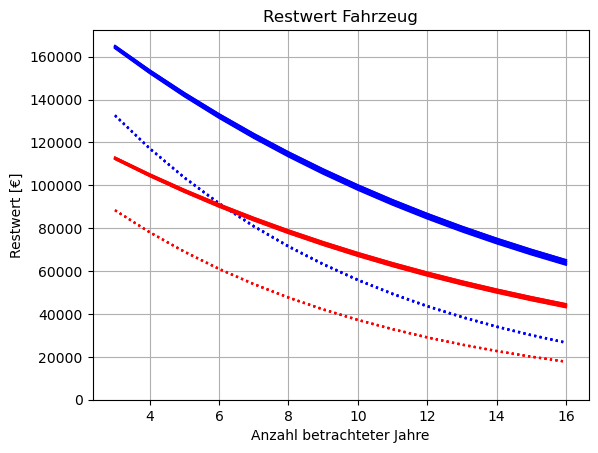

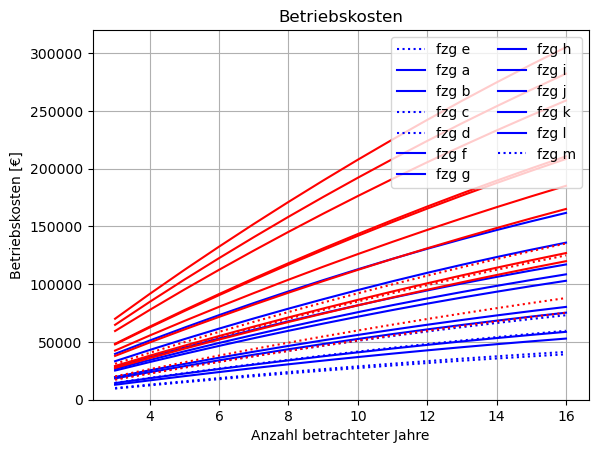

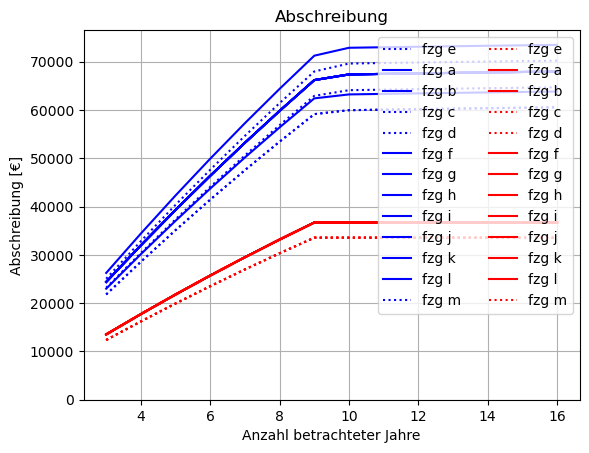

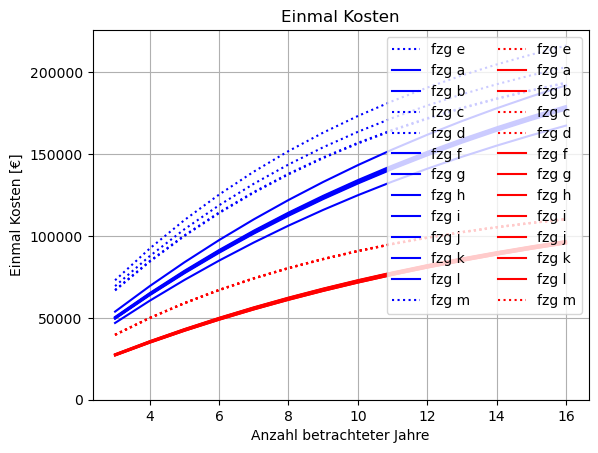

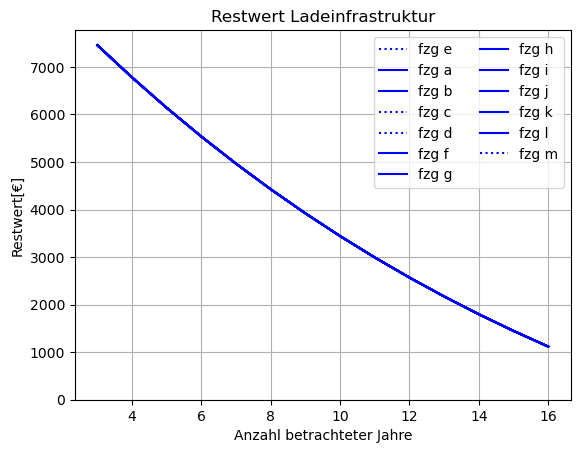

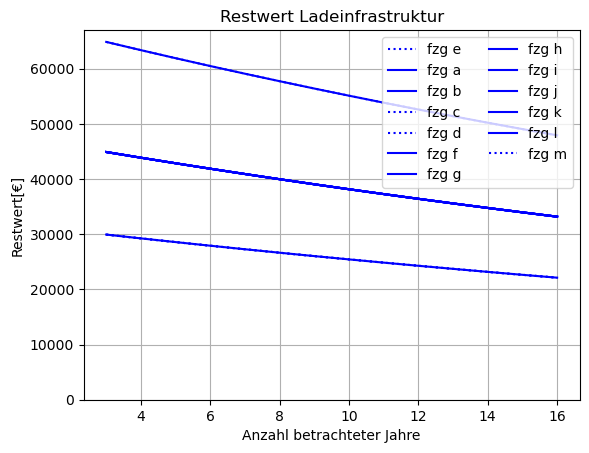

In [38]:
#4.3. Betrachtung einezelner Komponenten der Kostenaufteilung
#Details
#1. Restwert Fahrzeug
#2. Betrieb ohne Abschreibung
#3. Abschreibungen
#4. Festkosten
#5. REstwert LAdeinfrastruktur

#Restwert Fahrzeug
small_vehicles = ['WT-BR 391E ', 'WT-BR 270', 'FR-BR 1315', 'FR-BR 1317']

for key in restwert_e:
    x = list(restwert_e[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(restwert_e[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, linestyle=linestyle, color='blue')

for key in restwert_d:
    x = list(restwert_d[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(restwert_d[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, linestyle=linestyle, color='red')
    
    #plt.plot(x, y, label=new_label[key])  # Plot each line with a label corresponding to the key
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Restwert [€]')
plt.title('Restwert Fahrzeug')
#plt.legend(loc='upper right', ncol=2) # Show legend to identify each line
plt.ylim(bottom=0)
plt.grid(True)
plt.savefig(f'{save_path}Restwert.png')  
# Display the plot
plt.show()

#Betrieb (ohne Abschreibung)
for key in betrieb_e:
    x = list(betrieb_e[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(betrieb_e[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='blue')

for key in betrieb_d:
    x = list(betrieb_d[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(betrieb_d[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, linestyle=linestyle, color='red')
    
    #plt.plot(x, y, label=new_label[key])  # Plot each line with a label corresponding to the key
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Betriebskosten [€]')
plt.title('Betriebskosten')
plt.legend(loc='upper right', ncol=2) # Show legend to identify each line
plt.ylim(bottom=0)
plt.grid(True)
#plt.savefig(f'{save_path}Restwert.png')  
# Display the plot
plt.show()

#Abschreibungen
for key in betrieb_e_abschreibung:
    x = list(betrieb_e_abschreibung[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(betrieb_e_abschreibung[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='blue')

for key in betrieb_d_abschreibung:
    x = list(betrieb_d_abschreibung[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(betrieb_d_abschreibung[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='red')
    
    #plt.plot(x, y, label=new_label[key])  # Plot each line with a label corresponding to the key
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Abschreibung [€]')
plt.title('Abschreibung')
plt.legend(loc='upper right', ncol=2) # Show legend to identify each line
plt.ylim(bottom=0)
plt.grid(True)
#plt.savefig(f'{save_path}diesel_vs_elektro_Szenario_{Szenario}.png')  
# Display the plot
plt.show()

#Festkosten
for key in einmal_e:
    x = list(einmal_e[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(einmal_e[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='blue')

for key in einmal_d: #Kaufpreis-Restwert
    x = list(einmal_d[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(einmal_d[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='red')
    
    #plt.plot(x, y, label=new_label[key])  # Plot each line with a label corresponding to the key
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Einmal Kosten [€]')
plt.title('Einmal Kosten')
plt.legend(loc='upper right', ncol=2) # Show legend to identify each line
plt.ylim(bottom=0)
plt.grid(True)
#plt.savefig(f'{save_path}diesel_vs_elektro_Szenario_{Szenario}.png')  
# Display the plot
plt.show()

#Restwert Ladeinfrastruktur
for key in restwert_I:
    x = list(restwert_I[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(restwert_I[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='blue')
    
    #plt.plot(x, y, label=new_label[key])  # Plot each line with a label corresponding to the key
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Restwert[€]')
plt.title('Restwert Ladeinfrastruktur')
plt.legend(loc='upper right', ncol=2) # Show legend to identify each line
plt.ylim(bottom=0)
plt.grid(True)
#plt.savefig(f'{save_path}diesel_vs_elektro_Szenario_{Szenario}.png')  
# Display the plot
plt.show()

#Restwert Batterie
for key in restwert_b:
    x = list(restwert_b[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(restwert_b[key].values())[2:]
    linestyle = ':' if key in small_vehicles else '-'
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='blue')

# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Restwert[€]')
plt.title('Restwert Ladeinfrastruktur')
plt.legend(loc='upper right', ncol=2) # Show legend to identify each line
plt.ylim(bottom=0)
plt.grid(True)
#plt.savefig(f'{save_path}diesel_vs_elektro_Szenario_{Szenario}.png')  
# Display the plot
plt.show()


In [ ]:
#4.4. Gesamtkosten
kosten={}
kosten['elektro']={}
kosten['diesel']={}
kosten['differenz']={}
for jahr in range(1,17):
    kosten['elektro'][jahr]=0
    kosten['diesel'][jahr]=0
    kosten['differenz'][jahr]=0
    for fzg in FZG:
        kosten['elektro'][jahr]=kosten['elektro'][jahr]+kosten_elektro[fzg][jahr]
        kosten['diesel'][jahr]=kosten['diesel'][jahr]+kosten_diesel[fzg][jahr]

    kosten['differenz'][jahr]=kosten['diesel'][jahr]-kosten['elektro'][jahr]


for key in kosten:
    x = list(kosten[key].keys())  # The x-axis values (1, 2, 3, 4,...)
    y = list(kosten[key].values())  # The y-axis values (2, 4, 10, 11,...)


    # Plot each line with its corresponding color and line style
    plt.plot(x, y, label=key)
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Kosten[€]')
plt.title('Gesamtkosten elektro vs diesel')
plt.legend(loc='center left', bbox_to_anchor=(0.94, 0.5))
plt.grid(True)
# Show the major grid and style it slightly.
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.ylim(-100000, 3500000)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
plt.savefig(f'{save_path}absolute_kosten_Szenario_{kosten_szenario}.png')  
# Display the plot
plt.show()

In [ ]:
#4.5. Sensitivitäten
#jeweils in der Wirtschaftsfunktion Wert um 10% verändern und unter sens['xy'] abspeichern
a=Kosten(Szenario_fest, kosten_szenario, Restwert_szenario)
diff=a[13]
#diff_mit=diff
#sens['kalkulation']=diff
#sens['Inflation']=diff
#sens['Abschreibung_fzg']=diff
#sens['Abschreibung_LadeI']=diff
#sens['Abschreibung_Bat']=diff
#sens['diesel']=diff
#sens['strom']=diff
#sens['restwert_fzg']=diff
#sens['restwert_LadeI']=diff
#sens['restwert_Batterie']=diff
#sens['Preis_Batterie']=diff
#sens['Preis_Diesel']=diff
#sens['Preis_Elektro']=diff
#sens['Betrieb_LadeI']=diff

#Abbildung erstellen
sensi={}
for i in sens:
    sensi[i]={}
    sensitivität={}
    for fzg in FZG:
        sensitivität[fzg]=sens[i][fzg][16]/diff_mit[fzg][16]
    max_key = max(sensitivität, key=sensitivität.get)
    sensi[i]['max']=abs(1-sensitivität[max_key])
    min_key = min(sensitivität, key=sensitivität.get)
    sensi[i]['min']=abs(1-sensitivität[min_key])

categories = list(sensi.keys())
min_values = [sensi[category]['min'] for category in categories]
max_values = [sensi[category]['max'] for category in categories]
heights = [max_val - min_val for min_val, max_val in zip(min_values, max_values)]  # Height of each bar

# Create the plot
plt.figure(figsize=(10, 6))

# Plot vertical bars (boxes) for each category
plt.bar(categories, heights, bottom=min_values, color='lightblue', edgecolor='black')

# Add titles and labels
plt.title('Sensitivitäten (-10% bei Variable)', fontsize=16)
plt.ylabel('Sensitivitäten', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))


# Display und safe the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{save_path}Sensitivitäten.png')
plt.show()
sensi

In [40]:
#5. Matrix für alle Szenarienkombinationen
#5.1. Erstellen Matrix für alle Szenarienkombination (Kaufpreis, Restwert, Ladestrategie)
differenzen={}
for l in range(2): # Szenarien
    differenzen[l]={}
    for k in range(2):
        differenzen[l][k]={}
        for r in range(2):
            b=Verbraucht(650, l+1)
            laden_laderampe=b[0]
            laden_lp=b[1]
            laden_nacht=b[9]
            End_bat=b[2]
            batteriekapazität=b[3]
            distanz=b[4]
            große_lkw=b[5]
            kleine_lkw=b[6]
            FZG_groß=b[7]
            FZG_klein=b[8]
            a=Kosten(l+1, k, r)
            differenzen[l][k][r]=a[13]

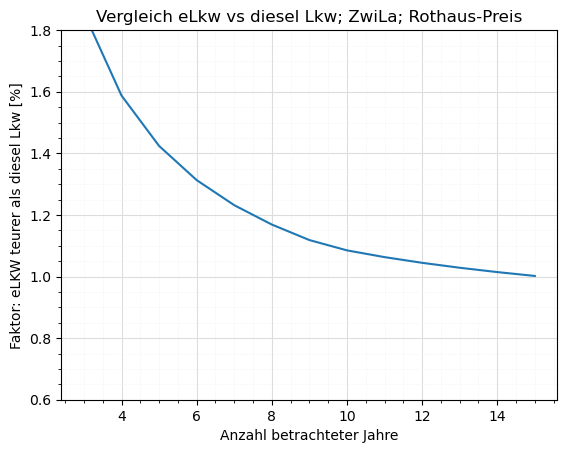

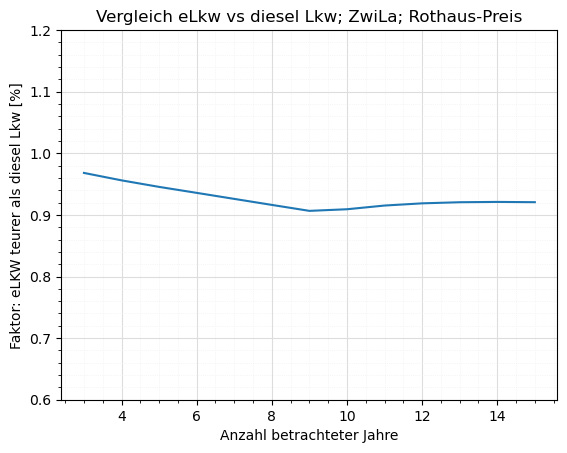

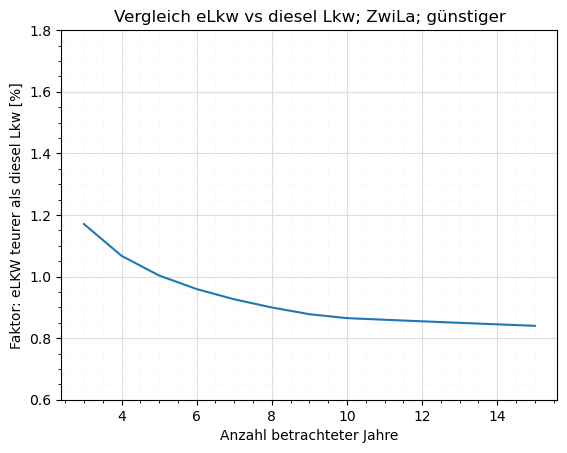

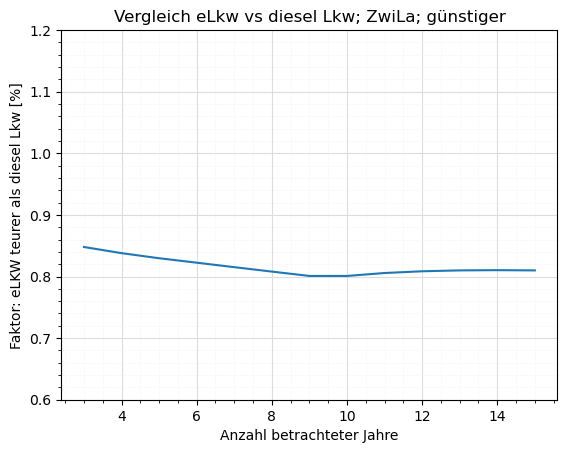

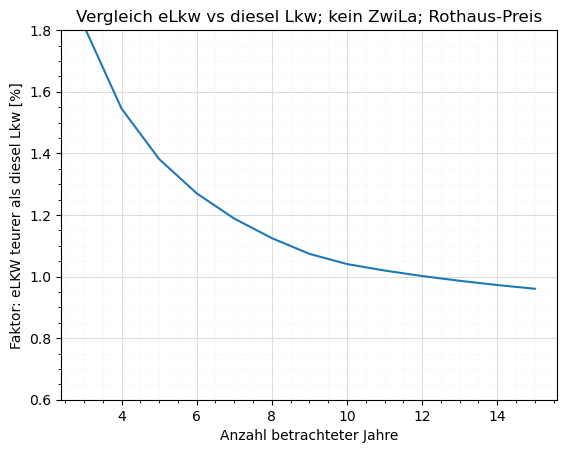

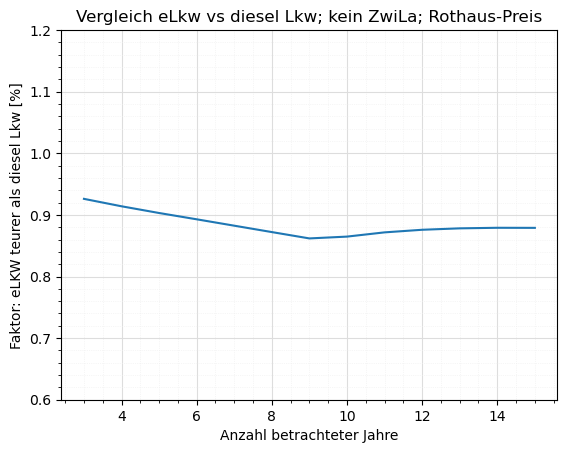

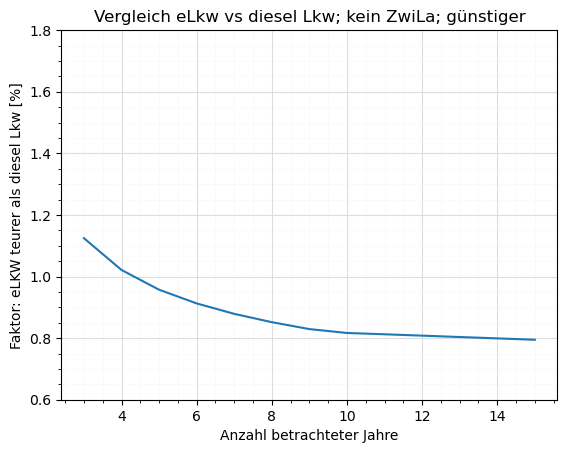

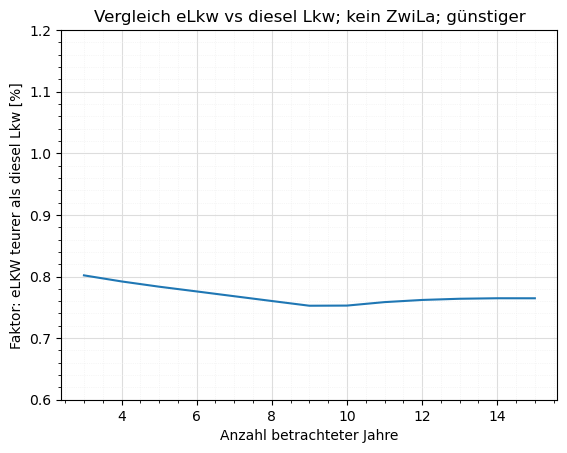

In [41]:
#5.2. Gegenüberstellung Diesel und elektro furhpark
for l in range(2): # Szenarien
    for k in range(2):
        for r in range(2):
            average={}
            for jahr in range(1,16):
                average[jahr]=0
                for fzg in FZG:
                    help=differenzen[l][k][r][fzg][jahr]
                    average[jahr]=average[jahr]+help
                average[jahr]=average[jahr]/len(FZG)
                
                
            x = list(average.keys())[2:]
            y = list(average.values())[2:]
            #linestyle = ':' if key in small_vehicles else '-'
            
                # Plot each line with its corresponding color and line style
            plt.plot(x, y,)
                    #plt.plot(x, y, label=new_label[key])  # Plot each line with a label corresponding to the key
            # Add labels and title
            plt.xlabel('Anzahl betrachteter Jahre')
            plt.ylabel('Faktor: eLKW teurer als diesel Lkw [%]')
            if l==0:  
                if k==0:
                    plt.title('Vergleich eLkw vs diesel Lkw; ZwiLa; Rothaus-Preis')
                elif k==1:
                    plt.title('Vergleich eLkw vs diesel Lkw; ZwiLa; günstiger')
            elif l==1:
                if k==0:
                    plt.title('Vergleich eLkw vs diesel Lkw; kein ZwiLa; Rothaus-Preis')
                elif k==1:
                    plt.title('Vergleich eLkw vs diesel Lkw; kein ZwiLa; günstiger')
            #plt.legend(loc='right',ncol=2) # Show legend to identify each line
            #plt.legend(loc='center left', bbox_to_anchor=(0.94, 0.5))
            plt.grid(True)
            # Show the major grid and style it slightly.
            plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
            # Show the minor grid as well. Style it in very light gray as a thin,
            # dotted line.
            plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
            # Make the minor ticks and gridlines show.
            plt.minorticks_on()
            if r==0:
                plt.ylim(0.6,1.8)
            elif r==1:
                plt.ylim(0.6,1.2)
            #plt.savefig(f'{save_path}diesel_vs_elektro_ohne_Anschaffungskosten')
            plt.savefig(f'{save_path}Durchschnitt_Szenario_{l}_Restwert_{r}_Preis{k}.png')  
            # Display the plot
            plt.show()

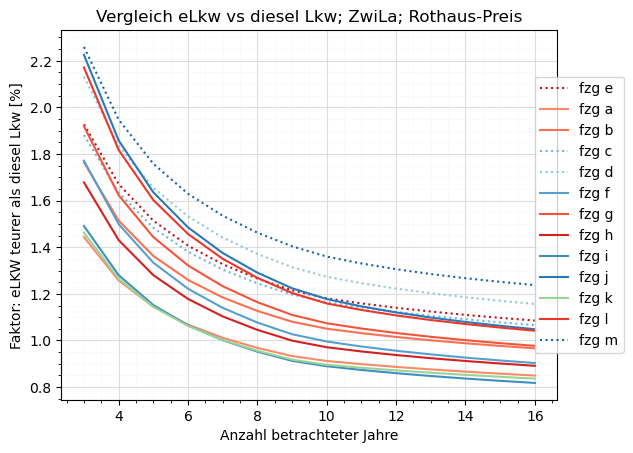

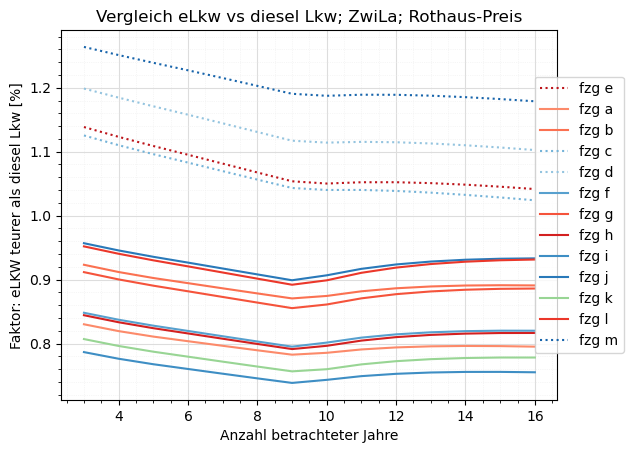

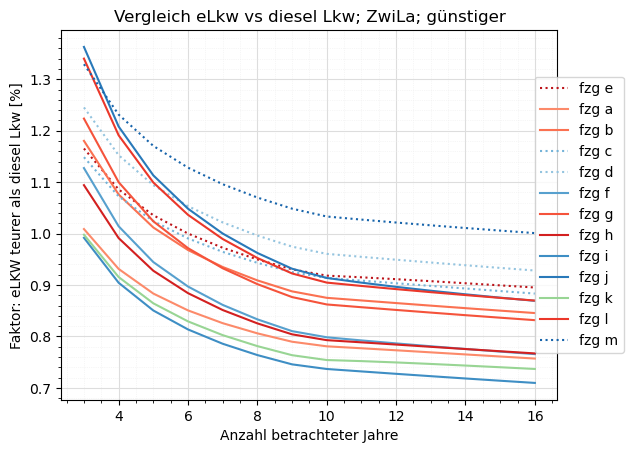

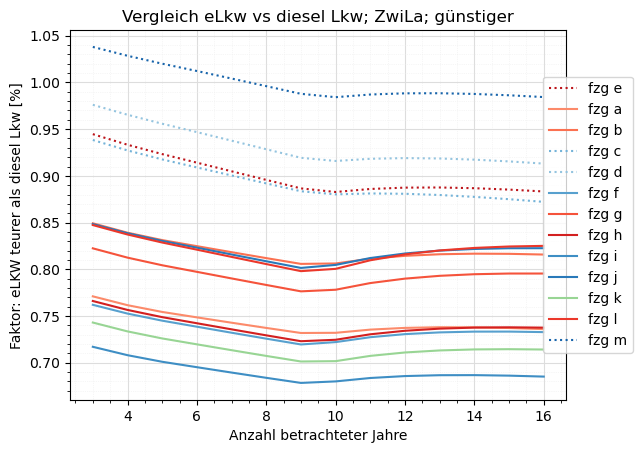

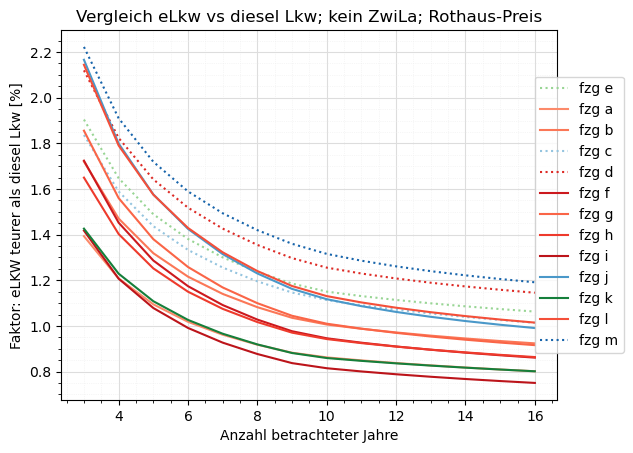

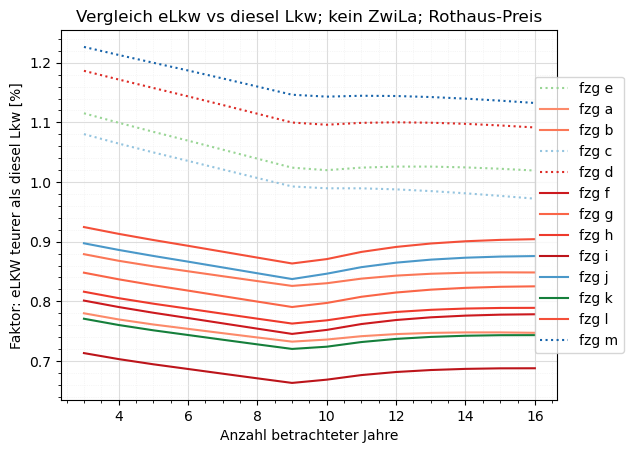

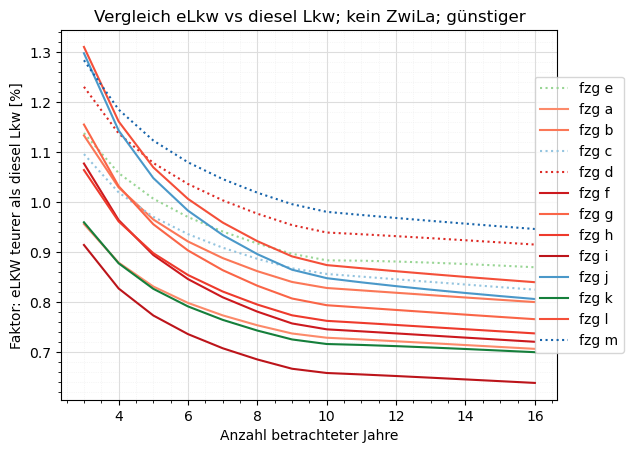

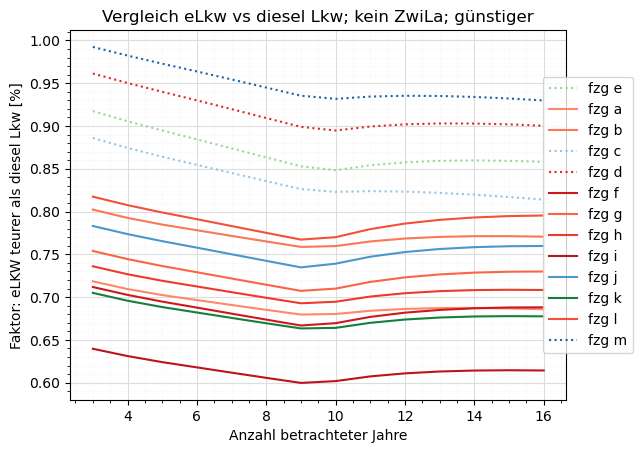

In [43]:
#5.3. Gegenüberstellung Diesel und Elektro nach Fahrzeug
for l in range(2): # Szenarien
    for k in range(2):
        for r in range(2):
            #Plot/ Vergleiche
            ### diesel vs elektro jedes fzg, wie verhällt es sich nach bestimmter anzahl von Jahren (armotisiert sich e vgl diesel)
            ### szenario 1 vs szenario 2: was ist günstiger, nach jahren?
            e_vs_d=differenzen[l][k][r]
            small_vehicles = ['WT-BR 391E ', 'WT-BR 270', 'FR-BR 1315', 'FR-BR 1317']
            
            if l==0: #(6x300kWh batterie, 6x450kWh, 1x650kWh)
                kleine_bat=[FZG[4], FZG[3], FZG[5], FZG[8], FZG[9], FZG[12]]
                mittlere_bat=[FZG[1], FZG[2], FZG[6], FZG[11], FZG[7], FZG[0]]
                große_bat=[FZG[10]]
            elif l==1: #(3x300kWh, 8x450kWh ,2x650 kWh)
                kleine_bat=[FZG[3], FZG[9], FZG[12]]
                mittlere_bat=[FZG[1], FZG[2], FZG[6], FZG[11], FZG[7], FZG[4], FZG[5], FZG[8]]
                große_bat=[FZG[0], FZG[10]]
            
            # Get color maps for different shades
            blue_colors = cm.Blues(np.linspace(0.4, 0.8, len(kleine_bat)))
            red_colors = cm.Reds(np.linspace(0.4, 0.8, len(mittlere_bat)))
            #yellow_colors = cm.YlOrBr(np.linspace(0.4, 0.8, len(große_bat)))
            green_colors = cm.Greens(np.linspace(0.4, 0.8, len(große_bat)))
            
            # Create a mapping from vehicles to their corresponding colors
            color_mapping = {}
            
            # Assign colors to blue vehicles
            for i, vehicle in enumerate(kleine_bat):
                color_mapping[vehicle] = blue_colors[i]

            # Assign colors to red vehicles
            for i, vehicle in enumerate(mittlere_bat):
                color_mapping[vehicle] = red_colors[i]
            
            # Assign colors to yellow vehicles
            for i, vehicle in enumerate(große_bat):
                color_mapping[vehicle] = green_colors[i]
            
            
            for key in e_vs_d:
                x = list(e_vs_d[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
                y = list(e_vs_d[key].values())[2:]  # The y-axis values (2, 4, 10, 11,...)
                linestyle = ':' if key in small_vehicles else '-'
                color = color_mapping.get(key, 'gray')  # Default to gray if not in any group
            
                # Plot each line with its corresponding color and line style
                plt.plot(x, y, label=new_label[key], linestyle=linestyle, color=color)
                    #plt.plot(x, y, label=new_label[key])  # Plot each line with a label corresponding to the key
            # Add labels and title
            plt.xlabel('Anzahl betrachteter Jahre')
            plt.ylabel('Faktor: eLKW teurer als diesel Lkw [%]')
            if l==0:  
                if k==0:
                    plt.title('Vergleich eLkw vs diesel Lkw; ZwiLa; Rothaus-Preis')
                elif k==1:
                    plt.title('Vergleich eLkw vs diesel Lkw; ZwiLa; günstiger')
            elif l==1:
                if k==0:
                    plt.title('Vergleich eLkw vs diesel Lkw; kein ZwiLa; Rothaus-Preis')
                elif k==1:
                    plt.title('Vergleich eLkw vs diesel Lkw; kein ZwiLa; günstiger')
            #plt.legend(loc='right',ncol=2) # Show legend to identify each line
            plt.legend(loc='center left', bbox_to_anchor=(0.94, 0.5))
            plt.grid(True)
            # Show the major grid and style it slightly.
            plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
            # Show the minor grid as well. Style it in very light gray as a thin,
            # dotted line.
            plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
            # Make the minor ticks and gridlines show.
            plt.minorticks_on()
            #plt.ylim(bottom=1)
            #plt.savefig(f'{save_path}diesel_vs_elektro_ohne_Anschaffungskosten')
            plt.savefig(f'{save_path}diesel_vs_elektro_Szenario_{l}_Restwert_{r}_Preis{k}.png')  
            # Display the plot
            plt.show()

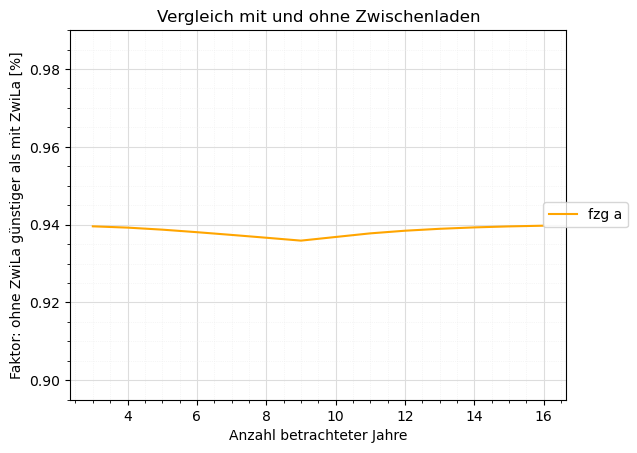

In [44]:
#5.4. Vergleich Ladestrategien (Beispielfahrzeug)
#Kostenszenario festlegen
kosten=0 #0=rothaus, 1=günstiger

Jahre_all=16

sz_keinzwla=differenzen[1][kosten][1]
sz_zwischenladen=differenzen[0][kosten][1]
#sz_keinzwla=kosten_elektro
diff_1={}
diff_2={}
for fzg in range(1):
    fzg=fzg+1
    diff_1[FZG[fzg]]={}
    diff_2[FZG[fzg]]={}
    for jahresszenario in range(1, Jahre_all+1):
        diff_1[FZG[fzg]][jahresszenario]=sz_zwischenladen[FZG[fzg]][jahresszenario]-sz_keinzwla[FZG[fzg]][jahresszenario]
        diff_2[FZG[fzg]][jahresszenario]=sz_keinzwla[FZG[fzg]][jahresszenario]/sz_zwischenladen[FZG[fzg]][jahresszenario]

new_label={'WT-BR 231': 'fzg a','WT-BR240': 'fzg b', 'WT-BR 391E ': 'fzg c', 'FR-BR 1315': 'fzg d', 'WT-BR 270': 'fzg e', 'WT-BR 229': 'fzg f', 'WT-BR 228': 'fzg g', 'WT-BR 2551': 'fzg h', 'WT-BR 608': 'fzg i', 'WT-BR 213': 'fzg j', 'WT-BR 225': 'fzg k', 'WT-BR 253': 'fzg l', 'FR-BR 1317': 'fzg m'}
small_vehicles = ['WT-BR 391E ', 'WT-BR 270', 'FR-BR 1315', 'FR-BR 1317']

for key in diff_2:
    x = list(diff_2[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(diff_2[key].values())[2:]  # The y-axis values (2, 4, 10, 11,...)
    linestyle = ':' if key in small_vehicles else '-' # Default to gray if not in any group

    # Plot each line with its corresponding color and line style
    plt.plot(x, y, label=new_label[key], linestyle=linestyle, color='orange')
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Faktor: ohne ZwiLa günstiger als mit ZwiLa [%]')
plt.title('Vergleich mit und ohne Zwischenladen')
plt.legend(loc='center left', bbox_to_anchor=(0.94, 0.5))
plt.grid(True)
# Show the major grid and style it slightly.
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
plt.ylim(0.895, 0.99)
#plt.savefig(f'{save_path}Szenario1vs_Szenario_kosten_{kosten}.png')  
# Display the plot
plt.show()

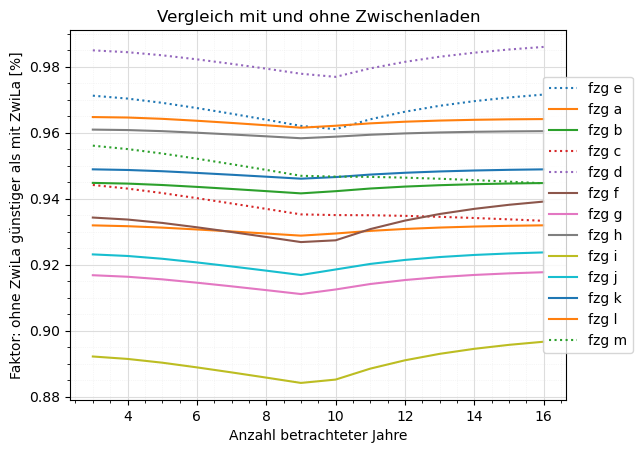

In [46]:
#5.4. Vergleich Ladestrategien (alle Fahrzeuge)
#Kostenszenario festlegen
kosten=1 #0=rothaus, 1=günstiger

Jahre_all=16
sz_keinzwla=differenzen[1][kosten][1]
sz_zwischenladen=differenzen[0][kosten][1]
#sz_keinzwla=kosten_elektro
diff_1={}
diff_2={}
for fzg in range(len(FZG)):
    diff_1[FZG[fzg]]={}
    diff_2[FZG[fzg]]={}
    for jahresszenario in range(1, Jahre_all+1):
        diff_1[FZG[fzg]][jahresszenario]=sz_zwischenladen[FZG[fzg]][jahresszenario]-sz_keinzwla[FZG[fzg]][jahresszenario]
        diff_2[FZG[fzg]][jahresszenario]=sz_keinzwla[FZG[fzg]][jahresszenario]/sz_zwischenladen[FZG[fzg]][jahresszenario]

new_label={'WT-BR 231': 'fzg a','WT-BR240': 'fzg b', 'WT-BR 391E ': 'fzg c', 'FR-BR 1315': 'fzg d', 'WT-BR 270': 'fzg e', 'WT-BR 229': 'fzg f', 'WT-BR 228': 'fzg g', 'WT-BR 2551': 'fzg h', 'WT-BR 608': 'fzg i', 'WT-BR 213': 'fzg j', 'WT-BR 225': 'fzg k', 'WT-BR 253': 'fzg l', 'FR-BR 1317': 'fzg m'}
small_vehicles = ['WT-BR 391E ', 'WT-BR 270', 'FR-BR 1315', 'FR-BR 1317']

    
for key in diff_2:
    x = list(diff_2[key].keys())[2:]  # The x-axis values (1, 2, 3, 4,...)
    y = list(diff_2[key].values())[2:]  # The y-axis values (2, 4, 10, 11,...)
    linestyle = ':' if key in small_vehicles else '-'
    #color = color_mapping.get(key, 'gray')  # Default to gray if not in any group

    # Plot each line with its corresponding color and line style
    plt.plot(x, y, label=new_label[key], linestyle=linestyle)
# Add labels and title
plt.xlabel('Anzahl betrachteter Jahre')
plt.ylabel('Faktor: ohne ZwiLa günstiger als mit ZwiLa [%]')
plt.title('Vergleich mit und ohne Zwischenladen')
plt.legend(loc='center left', bbox_to_anchor=(0.94, 0.5))
plt.grid(True)
# Show the major grid and style it slightly.
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# Make the minor ticks and gridlines show.
plt.minorticks_on()
plt.savefig(f'{save_path}Szenario1vs_Szenario_kosten_{kosten}.png')  
# Display the plot
plt.show()